In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'torch'
import keras
print(f"Keras version: {keras.__version__}")
print(f"Using backend: {keras.backend.backend()}")

Keras version: 3.10.0
Using backend: torch


In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU available: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print("Training will be significantly faster on GPU!")
else:
    device = torch.device("cpu")
    print("⚠ No GPU detected - using CPU")
    print("  Training will be slower. Consider using Google Colab or Kaggle Kernel for free GPU access.")

GPU available: Tesla T4
Memory: 15.83 GB
Training will be significantly faster on GPU!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import random
from collections import Counter


import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
ratings = pd.read_csv('ratings.csv')
ratings.nunique()

,0
userId,610
movieId,9724
rating,10
timestamp,85043


In [ ]:
n_users = int(ratings.nunique()['userId'])
n_movies = int(ratings.nunique()['movieId'])

In [ ]:
unique_movie_ids = ratings['movieId'].unique()
movie_idx = {mid:idx+1 for idx, mid in enumerate(unique_movie_ids)}

In [ ]:
ratings['movieId'] = ratings['movieId'].map(movie_idx)
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s', utc=True)

In [ ]:
num_movies = ratings['movieId'].nunique()
vocab_size = num_movies + 1  # padding index 0

### Preprocessing

In [ ]:
movies = pd.read_csv('movies.csv')

all_genres = set()
for g in movies['genres']:
    all_genres.update(g.split('|'))
all_genres.discard('(no genres listed)')
genre_list = sorted(list(all_genres))
genre_map = {g: i for i, g in enumerate(genre_list)}
num_genres = len(genre_list) # Should be 19


# Lookup table (row 0 is for padding), should have shape (9725, 19)
movie_genre_matrix = np.zeros((len(movie_idx) + 1, num_genres))

for mid, row in movies.iterrows():
    og_id = row['movieId']
    if og_id in movie_idx:
      mapped_id = movie_idx[og_id]
      genres = row['genres'].split('|')
      for genre_id in genres:
          if genre_id in genre_map:
              movie_genre_matrix[mapped_id, genre_map[genre_id]] = 1.0

print("Shape:", movie_genre_matrix.shape)

Shape: (9725, 19)


### Data Loader

In [ ]:
look_back = 12

ratings_sorted = ratings.sort_values(by=['userId', 'timestamp'])
user_grouped = ratings_sorted.groupby('userId')

user_sequences = {}
for user_id, group in user_grouped:
    movie_ids = group['movieId'].values
    rating_vals = group['rating'].values / 5.0 # Noramlization
    user_sequences[user_id] = list(zip(movie_ids, rating_vals))

In [ ]:
# Sliding windows
def create_windows(seq, look_back=look_back):
    X_ids, X_genres, X_ratings, y_ids = [], [], [], []

    for i in range(len(seq) - look_back):
        window = seq[i : i + look_back]
        target = seq[i + look_back]

        window_ids = [item[0] for item in window]
        window_ratings = [[item[1]] for item in window]
        window_genres = []
        for movie_id in window_ids:
            if movie_id == 0:
                window_genres.append(np.zeros(num_genres))
            else:
                window_genres.append(movie_genre_matrix[movie_id])

        X_ids.append(window_ids)
        X_genres.append(window_genres)
        X_ratings.append(window_ratings)
        y_ids.append(target[0])

    return X_ids, X_genres, X_ratings, y_ids

In [ ]:
train_ids, train_genres, train_ratings, train_y = [], [], [], []
val_ids,   val_genres,   val_ratings,   val_y   = [], [], [], []
test_ids,  test_genres,  test_ratings,  test_y  = [], [], [], []

for uid, seq in user_sequences.items():

    # Test set
    test_target = seq[-1]
    window_test = seq[-(look_back+1):-1]
    test_ids.append([x[0] for x in window_test])
    test_ratings.append([[x[1]] for x in window_test])
    test_genres.append([movie_genre_matrix[x[0]] if x[0]!=0 else np.zeros(num_genres) for x in window_test])
    test_y.append(test_target[0])

    # Validation set
    val_target = seq[-2]
    window_val = seq[-(look_back+2):-2]
    val_ids.append([x[0] for x in window_val])
    val_ratings.append([[x[1]] for x in window_val])
    val_genres.append([movie_genre_matrix[x[0]] if x[0]!=0 else np.zeros(num_genres) for x in window_val])
    val_y.append(val_target[0])

    # Training set
    train_seq = seq[:-2]
    ids, genres, ratings, y = create_windows(train_seq)
    train_ids.extend(ids)
    train_genres.extend(genres)
    train_ratings.extend(ratings)
    train_y.extend(y)

X_train, y_train = [np.array(train_ids), np.array(train_genres), np.array(train_ratings)], np.array(train_y)
X_val, y_val = [np.array(val_ids), np.array(val_genres), np.array(val_ratings)], np.array(val_y)
X_test, y_test = [np.array(test_ids), np.array(test_genres), np.array(test_ratings)], np.array(test_y)

print(f"Train Shapes: movieIds: {X_train[0].shape}, Genres: {X_train[1].shape}, Ratings: {X_train[2].shape}")

Train Shapes: movieIds: (92296, 12), Genres: (92296, 12, 19), Ratings: (92296, 12, 1)


### Model Definition

In [ ]:
# Re-define variables
look_back = 12
vocab_size = len(movie_idx) + 1
num_genres = 19

movie_input = Input(shape=(look_back,))
movie_emb = layers.Embedding(input_dim=vocab_size, output_dim=128)(movie_input)

genre_input = Input(shape=(look_back, num_genres))
genre_feat = layers.Dense(64, activation='relu')(genre_input)

rating_input = Input(shape=(look_back, 1))
rating_feat = layers.Dense(32, activation='relu')(rating_input)

# Incorporate context into LSTM model
context = layers.Concatenate(axis=2)([movie_emb, genre_feat, rating_feat])

lstm = layers.LSTM(256, recurrent_dropout=0.2, dropout=0.0)(context)
x = layers.Dense(512, activation='relu')(lstm)
x = layers.Dropout(0.1)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(vocab_size, activation='softmax')(x) # Softmax


model_v2 = Model(inputs=[movie_input, genre_input, rating_input], outputs=output)

model_v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy',
                 metrics=['sparse_categorical_accuracy',
                          tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5'),
                          tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top10')])

model_v2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 12, 19)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 12, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 12, 128)   │  1,244,800 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 12, 64)    │      1,280 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 12, 32)    │         64 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 12, 224)   │          0 │ embedding_1[0][0… │
│ (Concatenate)       │                   │            │ dense_6[0][0],    │
│                     │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    492,544 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 512)       │    131,584 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │    131,328 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     32,896 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 9725)      │  1,254,525 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,289,021 (12.55 MB)

 Trainable params: 3,289,021 (12.55 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [ ]:
# EARLY STOP
early_stop = EarlyStopping(monitor='val_top10', patience=5, mode='max', restore_best_weights=True)

history_v2 = model_v2.fit(x=X_train, y=y_train, batch_size=256, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stop],verbose=1)
result_v2 = model_v2.evaluate(X_test, y_test, batch_size=256, verbose=0)

loss_v2 = round(result_v2[0], 4)
top1_v2 = round(result_v2[1] * 100, 4)
top5_v2 = round(result_v2[2] * 100, 4)
top10_v2 = round(result_v2[3] * 100, 4)

print(f"Test Loss: {loss_v2}")
print(f"Top-1 Accuracy: {top1_v2}%")
print(f"Top-5 Accuracy: {top5_v2}%")
print(f"Top-10 Accuracy: {top10_v2}%")

Epoch 1/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - loss: 8.3834 - sparse_categorical_accuracy: 0.0018 - top10: 0.0164 - top5: 0.0087 - val_loss: 8.0315 - val_sparse_categorical_accuracy: 0.0033 - val_top10: 0.0295 - val_top5: 0.0180
Epoch 2/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - loss: 7.8868 - sparse_categorical_accuracy: 0.0024 - top10: 0.0229 - top5: 0.0122 - val_loss: 7.8689 - val_sparse_categorical_accuracy: 0.0016 - val_top10: 0.0246 - val_top5: 0.0148
Epoch 3/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - loss: 7.5636 - sparse_categorical_accuracy: 0.0045 - top10: 0.0364 - top5: 0.0189 - val_loss: 7.6341 - val_sparse_categorical_accuracy: 0.0066 - val_top10: 0.0426 - val_top5: 0.0230
Epoch 4/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - loss: 7.1939 - sparse_categorical_accuracy: 0.0073 - top10: 0.0561 - top5: 0.0301 - val_loss: 7.6210 - val_sparse_categorical_accuracy: 0.0049 - val_top10: 0.0393 - val_top5: 0.0197
Epoch 5/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms

# **Evaluation**

## Negative Sampling

In [ ]:
def negative_sampling(model, X_test, y_test, k_values=range(1,11), num_negatives=100):

    random.seed(3)

    all_probs = model.predict(X_test, batch_size=256, verbose=0)
    freqs = {k: 0 for k in k_values}
    num_users = len(y_test)

    X_test_ids = X_test[0]

    for i in range(num_users):
        target_item = y_test[i]
        user_history_set = set(X_test_ids[i])
        user_history_set.add(target_item)

        # Negative sampling
        negatives = set()
        while len(negatives) < num_negatives:
            neg_id = random.randint(1, vocab_size-1)
            if neg_id not in user_history_set:
                negatives.add(neg_id)

        candidates = [target_item] + list(negatives)
        scores = all_probs[i][candidates]
        ranked_indices = np.argsort(scores)[::-1]
        rank = np.where(ranked_indices == 0)[0][0] + 1

        for k in k_values:
            if rank <= k:
                freqs[k] += 1

    results = {}
    for k in k_values:
        HR = round((freqs[k] / num_users)*100, 2)
        results[k] = HR
        if k % 5 == 0:
          print(f"Hit Ratio@{k}: {HR}%")

    return results

results_negative_sampled = negative_sampling(model_v2, X_test, y_test)

Hit Ratio@5: 56.07%
Hit Ratio@10: 69.51%


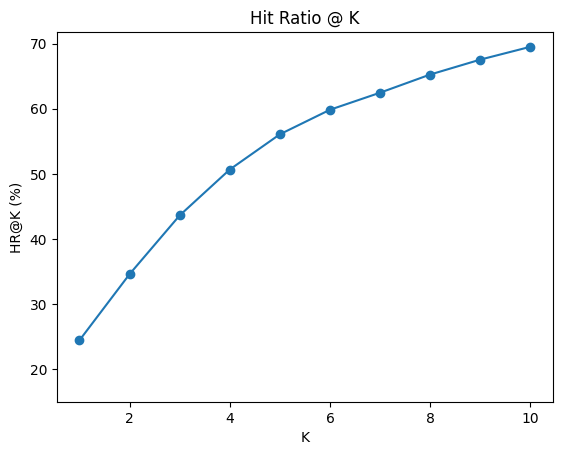

In [ ]:
ks = results_negative_sampled.keys()
HRs = [results_negative_sampled[k] for k in ks]

plt.figure()
plt.plot(ks, HRs, marker='o')
plt.xlabel("K")
plt.ylabel("HR@K (%)")
plt.title("Hit Ratio @ K")
plt.ylim(bottom=15)
plt.show()

In [ ]:
results_negative_sampled

{1: 24.43,
 2: 34.59,
 3: 43.61,
 4: 50.66,
 5: 56.07,
 6: 59.84,
 7: 62.46,
 8: 65.25,
 9: 67.54,
 10: 69.51}

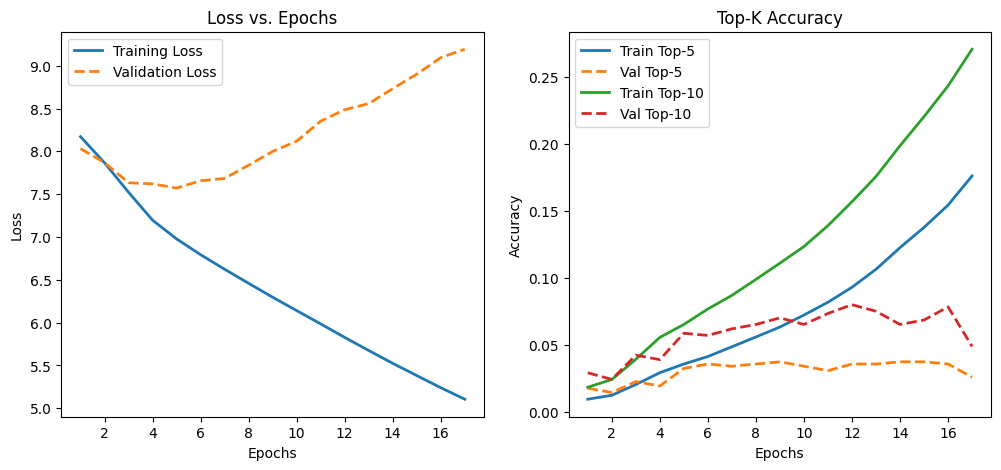

In [ ]:
def plot_training_metrics(history):
    history_dict = history.history
    epochs = range(1, len(history_dict['loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_dict['loss'], label='Training Loss', linewidth=2)
    plt.plot(epochs, history_dict['val_loss'], label='Validation Loss', linestyle='--', linewidth=2)
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Top-5 and Top-10 Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_dict['top5'], label='Train Top-5', linewidth=2)
    plt.plot(epochs, history_dict['val_top5'], label='Val Top-5', linestyle='--', linewidth=2)
    plt.plot(epochs, history_dict['top10'], label='Train Top-10', linewidth=2)
    plt.plot(epochs, history_dict['val_top10'], label='Val Top-10', linestyle='--', linewidth=2)
    plt.title('Top-K Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_metrics(history_v2)